# Project Goal

Beta Bank has had customers leaving and would like to retain its customers. Therefore, Beta Bank seeks to predict the likelihood of a customer leaving the bank soon. We will use data on clients’ past behavior and termination of contracts with the bank to build a model that can predict whether or not a client will leave based on client information. Our goal is to train a model with a minimum F1 score of 0.59.

### Initializing Data

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [42]:
df = pd.read_csv('Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


The data contains 10000 records and 14 columns:

Features
 - RowNumber — data string index
 - CustomerId — unique customer identifier
 - Surname — surname
 - CreditScore — credit score
 - Geography — country of residence
 - Gender — gender
 - Age — age
 - Tenure — period of maturation for a customer’s fixed deposit (years)
 - Balance — account balance
 - NumOfProducts — number of banking products used by the customer
 - HasCrCard — customer has a credit card
 - IsActiveMember — customer’s activeness
 - EstimatedSalary — estimated salary

Target
 - Exited — сustomer has left ("1" = exited, "0" = remained)
 
All of the variables are numeric except 'surname', 'geography' and 'gender'. These are object types. We will need the data to be in numeric form. Since 'surname' is unlikely to predict the target variable, we will drop this variable from the dataframe. However, 'geography' and 'gender' may help predict the target so we will encode these as numeric variables. We will convert all column names to lowercase to keep code clean. We will also convert floats to integers since some methods require integers.

In [44]:
# Checking for duplicates

duplicate = df[df.duplicated()]

duplicate

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


There are no duplicate rows.

## Data Preprocessing <a class="anchor" id="section_1_1"></a>

### Converting to Lowercase <a class="anchor" id="section_1_1"></a>

In [45]:
# Converting all column names to lowercase

df.columns = df.columns.str.lower()

### Missing Values <a class="anchor" id="section_1_1"></a>

In [46]:
# Checking for missing values

df.isnull().sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

The only variable with missing values is 'tenure'. It has 909 missing values, which is roughly 9% of the data. Let's check the value counts and a histogram to see the distribution of 'tenure' values.

In [47]:
# Checking value counts of 'tenure'

df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

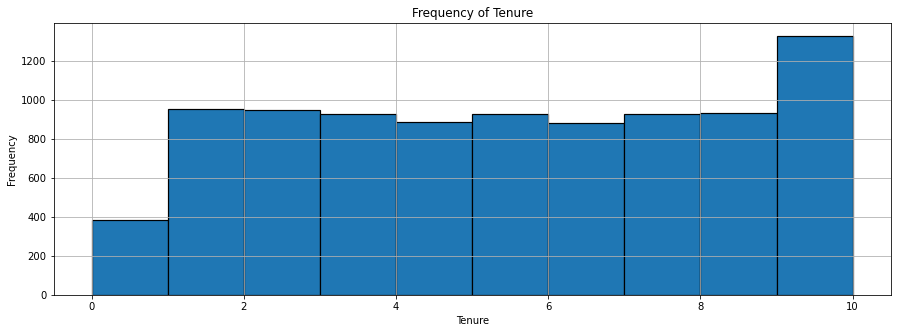

In [48]:
# Plotting distribution of 'tenure'

df['tenure'].hist(edgecolor='black', linewidth=1.2, figsize=(15,5))
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.title('Frequency of Tenure')
plt.show()

The values in 'tenure' are pretty normally distributed overall. We would prefer not to lose 10% of the data, so let's replace missing values with the mean of the 'tenure' values.

In [49]:
# Replacing missing values in 'tenure' with mean of 'tenure' values

df['tenure'].fillna(value=df['tenure'].mean(), inplace=True)

df.isnull().sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

### Convert to Integers <a class="anchor" id="section_1_1"></a>

In [50]:
# Converting 'tenure', 'balance' and 'estimatedsalary' from float to integer types

df['tenure'] = df['tenure'].astype(int)
df['balance'] = df['balance'].astype(int)
df['estimatedsalary'] = df['estimatedsalary'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rownumber        10000 non-null  int64 
 1   customerid       10000 non-null  int64 
 2   surname          10000 non-null  object
 3   creditscore      10000 non-null  int64 
 4   geography        10000 non-null  object
 5   gender           10000 non-null  object
 6   age              10000 non-null  int64 
 7   tenure           10000 non-null  int32 
 8   balance          10000 non-null  int32 
 9   numofproducts    10000 non-null  int64 
 10  hascrcard        10000 non-null  int64 
 11  isactivemember   10000 non-null  int64 
 12  estimatedsalary  10000 non-null  int32 
 13  exited           10000 non-null  int64 
dtypes: int32(3), int64(8), object(3)
memory usage: 976.7+ KB


### Drop Columns <a class="anchor" id="section_1_1"></a>

The 'surname' variable will result in thousands of dummy variables that will stress the model. Since 'surname' is unlikely to predict the target variable, we will drop this variable from the dataframe. We will also drop 'rownumber' and 'customerid' since they do not provide any useful information and will confuse the models.

In [51]:
# Dropping 'surname' column

df = df.drop(['surname', 'rownumber', 'customerid'], axis=1)
df

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0,1,1,1,101348,1
1,608,Spain,Female,41,1,83807,1,0,1,112542,0
2,502,France,Female,42,8,159660,3,1,0,113931,1
3,699,France,Female,39,1,0,2,0,0,93826,0
4,850,Spain,Female,43,2,125510,1,1,1,79084,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0,2,1,0,96270,0
9996,516,France,Male,35,10,57369,1,1,1,101699,0
9997,709,France,Female,36,7,0,1,0,1,42085,1
9998,772,Germany,Male,42,3,75075,2,1,0,92888,1


### Encode Categorical Variables with OHE <a class="anchor" id="section_1_1"></a>

We plan to initially use a LogisticRegression model so we need to convert the feature categorical variables into numerical variables using an encoder before training the model.

However, 'geography' and 'gender' may help predict the target so we will encode these as numeric variables. These OHE variables have few categories and they are unlikely to be so predictive so we will use OHE encoding for the tree models as well.

Let's check how many columns will be added by OHE of 'gender' and 'geography'. Let's check the unique values in 'geography'

In [52]:
# Checking unique values in 'gender'

df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [53]:
# Checking unique values in 'geography'

df['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

There are only 2 categories in 'gender' and 3 categories in the 'geography' variable so encoding will not add too many columns to our dataframe. We will drop the first column of each variable to avoid a dummy trap.

In [54]:
# Encoding categorical variables

df_ohe = pd.get_dummies(df, drop_first = True)
df_ohe

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0,2,1,0,96270,0,0,0,1
9996,516,35,10,57369,1,1,1,101699,0,0,0,1
9997,709,36,7,0,1,0,1,42085,1,0,0,0
9998,772,42,3,75075,2,1,0,92888,1,1,0,1


After encoding, our dataframe has 14 columns.

### Assign the Target Variable  <a class="anchor" id="section_1_1"></a>

Our goal is to predict which customers will exit the bank based on the behavior of customers with similar features. We will assign 'exited' as our target variable and train our model to predict whether or not a customer exited the bank.

In [55]:
# We will assign 'exited' as the target variable, the feature we need to predict, and the remaining attributes as the features.
 
features = df_ohe.drop(['exited'], axis=1)
target = df_ohe['exited']
 
print(features.shape)
print(target.shape)

(10000, 11)
(10000,)


### Examine Balance of Classes  <a class="anchor" id="section_1_1"></a>

Before we train our model, we need to know the class distribution of 'exited'.

In [56]:
# Checking value counts of 'exited'

df_ohe['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

There is an imbalance between the classes. 20% of customers exited and 80% did not. We will account for this imbalance later in the analysis.

### Splitting the Dataframe 3-Way <a class="anchor" id="chapter1"></a>

First we will start with the source data and split it into three parts: training, validation, and test. This way, we can compare three models and use the test set for the final evaluation of the best model. We will leave as much data for the training as possible but make the sizes of the validation set and the test set equal. This will give us a source data split into a 3:1:1 ratio or  60% training, 20% validation, and 20% testing.

In [57]:
# Splitting data into 60% training dataset, 20% training dataset, 20% test dataset in two steps:
# First, we split data into 80% training and 20% test
 
df_train, df_test = train_test_split(df_ohe, test_size=0.20, random_state=12345)
 
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']
features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']
 
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(8000, 11)
(8000,)
(2000, 11)
(2000,)


In [58]:
# Then, we split data using a 0.25% test size for the validation set, effectively creating a 60% training dataset and a 20% validation dataset
 
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=12345)
 
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']
 
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)


### Standardize the Data  <a class="anchor" id="section_1_1"></a>
We need to scale the features so that features with higher values do not get unnecessary weighting during the model training. We will used standard scaler to standardize the data.

In [59]:
# Standardizing the data

numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
 
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
pd.options.mode.chained_assignment = None
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric]= scaler.transform(features_test[numeric])

## Pilot Training <a class="anchor" id="chapter1"></a>

We will initially train a model using LogisticRegression.

In [60]:
# Developing a model with LogisticRegression
 
model =  LogisticRegression(random_state=12345, solver='liblinear') 
model.fit(features_train, target_train)

LogisticRegression(random_state=12345, solver='liblinear')

### Evaluate the Model<a class="anchor" id="chapter1"></a>

In [61]:
# Checking F1 score of the Logistic Regression Model

predictions = model.predict(features_valid)
print('F1:', f1_score(target_valid, predictions))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC score:',auc_roc)

F1: 0.30131826741996237
AUC-ROC score: 0.77053625784629


For the Logistic Regression Model F1 score was 0.30, which is relatively low, and the AUC_ROC score was 0.77. This was likely due to the class imbalance. 

## Correcting Class Imbalance <a class="anchor" id="chapter1"></a>

One of the ways to improve the accuracy of our model is to correct the class imbalance in our target variable by making the rare class weigh more.

We will use various methods to adjust the class imbalance. 

### Balancing <a class="anchor" id="chapter1"></a>

In [62]:
# Using 'balanced' paramter to correct class imbalance

model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC score:',auc_roc)

F1: 0.4772117962466488
AUC-ROC score: 0.7726344300521841


Using a balanced parameter, the F1 score was 0.48, still low. The AUC_ROC was still 0.77.

### Upsampling <a class="anchor" id="chapter1"></a>

We will create a function for upsampling. The ratio of "1" to "0" in our sample is about 2:8 so we will need to repeat the "1" 4 times to correct the class imbalance.

In [63]:
# Creating a function for upsampling

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
 
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
 
    return features_upsampled, target_upsampled 

In [64]:
# Applying upsampling to our training set

features_upsampled, target_upsampled = upsample(
    features_train, target_train, 4
)
 
print(features_upsampled.shape)
print(target_upsampled.shape)

(9657, 11)
(9657,)


In [65]:
# Retraining model using upsampling set

model = LogisticRegression(solver='liblinear', random_state=12345) 
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC score:',auc_roc)

F1: 0.47585601404740996
AUC-ROC score: 0.7726550938693635


The F1 score of the LogisticRegression model after unsampling was 0.48 and the AUC_ROC was 0.77.

### Downsampling <a class="anchor" id="chapter1"></a>

We can also use downsampling to reduce the more common class in the set.

In [66]:
# Creating a function for downsampling to reduct the class of "0" in the set.

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_downsampled = np.concatenate([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = np.concatenate([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345) 
 
    return features_downsampled, target_downsampled

In [67]:
# Applying downsampling to our training set

features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.25
)
 
print(features_downsampled.shape)
print(target_downsampled.shape)

(2414, 11)
(2414,)


In [68]:
# Retraining model using downsampling set

model = LogisticRegression(solver='liblinear', random_state=12345) 
model.fit(features_downsampled, target_downsampled)

predictions_down = model.predict(features_valid) 
print('F1:', f1_score(target_valid, predictions_down))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC score:',auc_roc)

F1: 0.4757709251101322
AUC-ROC score: 0.7737979619118164


The F1 score was 0.48 and the AUC_ROC was 0.77, after downsampling.

Now, we will train different models and compare the models to the LogisticRegression models to find the best model.

## Develop Different Models <a class="anchor" id="chapter1"></a>

We trained a LogisticRegression model. To find the best model, we will also train a RandomForest Classifier model and a DecisionTreeClassifier model.
 
We will investigate the quality of different models and simultaneously tune the hyperparameters. We will use functions to apply the model to the data and use different hyperparameters for each iteration. This will inform us of the best hyperparameters to use with the best model. We will use the fit() method for training, and the predict() method for testing. We will use the F1 score and the AUC_ROC to evaluate each model.

### RandomForest Classifier <a class="anchor" id="chapter1"></a>

In [69]:
# Developing a model with RandomForestClassifier
 
best_score = 0
best_est = 0
for est in range(1, 11): # choose hyperparameter range
    model = RandomForestClassifier(random_state=12345, n_estimators= est) 
    model.fit(features_upsampled, target_upsampled)
    
    predictions = model.predict(features_valid)
    score = f1_score(target_valid, predictions)
    if score > best_score:
        best_score = score # save best f1 score on validation set
        best_est = est # save number of estimators corresponding to best score
        
print("F1 of the best model on the validation set (n_estimators = {}): {}".format(best_est, best_score))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC score:',auc_roc)

F1 of the best model on the validation set (n_estimators = 7): 0.5795601552393274
AUC-ROC score: 0.8142608949976078


The RandomForestClassifier (n_estimators = 7) had an F1 score of 0.58 and a AUC_ROC score of 0.81.

### DecisionTreeClassifier Model <a class="anchor" id="section_1_1"></a>


In [70]:
# Developing a model with DecisionTreeClassifier
 
best_model = None
best_result = 0

for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_upsampled, target_upsampled)
    
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:  # save best f1 result on validation set
        best_model = model
        best_result = result
        
print("max_depth =", depth)
print("F1 score of the best model on the validation set:", best_result)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC score:',auc_roc)

max_depth = 5
F1 score of the best model on the validation set: 0.47585601404740996
AUC-ROC score: 0.818801371441651


The F1 score for the DecisionTreeClassifier Model (max_depth = 5) was 0.48 and the AUC-ROC was 0.82.

### Best Model <a class="anchor" id="chapter1"></a>

The best model is the RandomForestClassifier model. Let's evaluate this model with the test set.

## Final Model Test <a class="anchor" id="chapter1"></a>

### Assess the Model Using a Test Set <a class="anchor" id="section_1_1"></a>

We will check quality of the RandomForestClassifier model we trained using the test set.

In [71]:
# Checking the quality of the RandomForestClassifier model using the test set.
 
model = RandomForestClassifier(random_state=12345, n_estimators= 17) # set number of trees
model.fit(features_upsampled, target_upsampled) # train model on training set
    
predicted_test = model.predict(features_test)
F1 = f1_score(target_test, predicted_test)
print('F1 score', F1)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC score:',auc_roc)

F1 score 0.5910224438902743
AUC-ROC score: 0.8228006148280372


The RandomForestClassifier (n_estimators=17) had an F1 score of 0.59 and an AUC_ROC score of 0.82.  The n_estimators needed to be adjusted to 17 to improve the efficacy of the model.

## Model Sanity Check <a class="anchor" id="section_1_1"></a>

We will use a confusion Matrix to see if our model is really efficient at predicting the positive class.

In [72]:
target_pred = model.predict(features_test)
acc = model.score(features_test, target_test)
acc

0.836

In [73]:
# Calculating a confusion matrix
conf_matrix = metrics.confusion_matrix(target_test, target_pred)

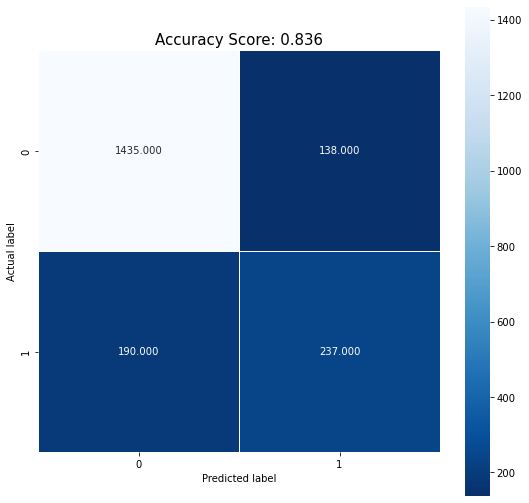

In [74]:
 # Plotting a confusion matrix
 
plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title(all_sample_title, size = 15);

According to the confusion matrix, the model is predicting both classes and has a precision and recall rate that indicates the model performs better than random.

## General Conclusion <a class="anchor" id="chapter1"></a>


Beta Bank seeks to predict the likelihood of a customer leaving the bank soon. We used data on clients’ past behavior and termination of contracts with the bank to build a model that can predict whether or not a client will leave based on client information.

The data contains 10000 records and 14 columns. All of the variables are numeric except 'surname', 'geography' and 'gender'. These are object types. Before encoding ‘gender’ and ‘geogrpahy’ to be numeric variables,  we dropped 'surname' from the dataframe. It would create too many columns and was unlikely to predict the target. We also dropped  'rownumber' and 'customerid' since they did not provide any useful information and would confuse the models.We converted all column names to lowercase to keep code clean and converted floats to integers. There were no duplicates. 

The only variable with missing values was 'tenure'. There were 909 missing values so dropping them would delete 9% of the data. The distribution of ‘tenure’ was pretty normal so we, therefore, filled in the missing values with the mean.

We intially trained a model using LogisticRegression. Therefore, we used OHE to encode the categorical variables ‘gender’ and ‘geography’. We dropped ‘surname’ because it was unlikely to predict the target variable and would create too many columns. After OHE, the dataframe had 14 columns. We standardized the data. We assigned ‘exited’ as the target variable. We examined the balance of classes. There were 20% of ‘exited’ or “1” and 80% ‘did not exit’ or “0”, indicating a class imbalance. 

We split the data into a 3:1:1 ratio of 60% training, 20% validation, and 20% testing. We standardized the data. We trained a model using LogisticRegression. For the Logistic Regression Model F1 score was 0.30, which is relatively low, and the AUC_ROC score was 0.77. This was likely due to the class imbalance. 

We corrected the class imbalance using three approaches.Using a balanced parameter, the F1 score was 0.48, still low. The AUC_ROC was still 0.77. The F1 score of the LogisticRegression model after unsampling was 0.48 and the AUC_ROC was 0.77. The F1 score was 0.48 and the AUC_ROC was 0.77, after downsampling.

We then developed different models using RandomForestClassifier and DecisionTreeClassifier. The RandomForestClassifier (n_estimators = 7) had an F1 score of 0.58 and a AUC_ROC score of 0.81.  The F1 score for the DecisionTreeClassifier Model (max_depth = 5) was 0.48 and the AUC-ROC was 0.82. The RandomForestClassifier has the best F1 score so we used this model and evaluated it with  the test set.

The RandomForestClassifier (n_estimators=17) with the test set had an F1 score of 0.59 and an AUC_ROC score of 0.82.  The n_estimators needed to be adjusted to 17 to improve the efficacy of the model. We found an accuracy score of 0.84 on model.  To check the sanity of our model, we checked a confusion matrix and found that the model predicted the target variable more often than a random model, indicating the efficacy of our model.